In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm


In [2]:
# colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# file_path = '/content/drive/MyDrive/data/'
file_path = '../data_nyc/'

In [4]:
# load data

zone = gpd.read_file(file_path+'temp.geojson', engine='pyogrio')
zone_time = pd.read_csv(file_path+'temp.csv')
zone_time['time'] = pd.to_datetime(zone_time['time'], format='%H:%M').dt.strftime('%H:%M')
zone['time'] = zone_time['time'].values


o3 = gpd.read_file(file_path+'o3.geojson')
o3_time = pd.read_csv(file_path+'o3.csv')
o3_time['time'] = pd.to_datetime(o3_time['time'], format='%H:%M').dt.strftime('%H:%M')
o3['time'] = o3_time['time'].values

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


In [5]:
# merge climate and air pollution data

temp = zone.copy()
o3_temp = o3.copy()

temp['time'] = temp['time'].astype(str)
o3_temp['time'] = o3_temp['time'].astype(str)
temp['date'] = temp['date'].astype(str)
o3_temp['date'] = o3_temp['date'].astype(str)


o3_temp = o3_temp.drop(columns=['ZONEDIST'])

df = temp.merge(
    o3_temp,
    on=['geometry', 'time', 'date'],
    how='inner',
    suffixes=('_left', '_right')
)
df = df.drop(columns=['ZONEDIST'])
df['o3 temp'] = df['o3 measurement']
df.shape

(1643496, 24)

In [6]:
'''
temp_save = temp[temp['date'] <= '2024-01-01']
o3_temp_save = o3_temp[o3_temp['date'] <= '2024-01-01']

temp_save.to_file(file_path+'temp1.geojson', driver='GeoJSON')
o3_temp_save.to_file(file_path+'o3_temp1.geojson', driver='GeoJSON')

temp_save.to_csv(file_path+'temp1.csv', index=False)
o3_temp_save.to_csv(file_path+'o3_temp1.csv', index=False)
'''

"\ntemp_save = temp[temp['date'] <= '2024-01-01']\no3_temp_save = o3_temp[o3_temp['date'] <= '2024-01-01']\n\ntemp_save.to_file(file_path+'temp1.geojson', driver='GeoJSON')\no3_temp_save.to_file(file_path+'o3_temp1.geojson', driver='GeoJSON')\n\ntemp_save.to_csv(file_path+'temp1.csv', index=False)\no3_temp_save.to_csv(file_path+'o3_temp1.csv', index=False)\n"

In [7]:
# back up data
df_temp = df.copy()

In [8]:
df = df_temp.copy()

In [9]:
df = df[df['date'] < '2024-03-01']

In [10]:
# time features
df['date'] = pd.to_datetime(df['date'])
df['hour'] = pd.to_datetime(df['time'], format='%H:%M').dt.hour
df['weekday'] = df['date'].dt.weekday
df['month'] = df['date'].dt.month

# Sin-Cos Encoding of Periodic Variables
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/7)


# geo features
df['x'] = df['geometry'].centroid.x
df['y'] = df['geometry'].centroid.y
scaler_xy = StandardScaler()
df[['x', 'y']] = scaler_xy.fit_transform(df[['x', 'y']])

# climate features
climate_cols = [
    'temperature_2m', 'lake_mix_layer_temperature', 'lake_shape_factor',
    'snowfall', 'snowmelt', 'runoff', 'surface_runoff', 'sub_surface_runoff',
    'skin_reservoir_content', 'u_component_of_wind_10m', 'v_component_of_wind_10m',
    'surface_pressure', 'total_precipitation',
    'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation'
]

scaler = StandardScaler()
scaled_climate = scaler.fit_transform(df[climate_cols])
df[climate_cols] = pd.DataFrame(scaled_climate, columns=climate_cols, index=df.index)

In [11]:
def add_neighborhood_features(gdf, features, buffer_radius=1000):
    gdf = gdf.copy()
    gdf['geometry_buffer'] = gdf.geometry.buffer(buffer_radius)
    enriched_rows = []

    for dt in tqdm(gdf['date'].unique(), desc="Processing dates"):
        for hr in gdf['time'].unique():
            sub = gdf[(gdf['date'] == dt) & (gdf['time'] == hr)]
            if sub.empty:
                continue
            sub_reset = sub.reset_index()

            right_df = gdf[(gdf['date'] == dt) & (gdf['time'] == hr)][['geometry'] + features]

            joined = gpd.sjoin(
                sub_reset.set_geometry('geometry_buffer'),
                right_df,
                how='left',
                predicate='intersects'
            )

            if 'index' not in joined.columns:
                continue  

            try:
                agg = joined.groupby('index')[features].mean()
            except KeyError as e:
                print(f"Skipping {dt} {hr} due to missing columns: {e}")
                continue

            agg.columns = [f'{col}_neigh_mean' for col in agg.columns]
            sub = sub.join(agg, how='left')
            enriched_rows.append(sub)

    result = pd.concat(enriched_rows)
    result = result.set_geometry('geometry')
    result = result.drop(columns='geometry_buffer')
    return result


# combine 
all_feature_cols = climate_cols + [f"{col}_neigh_mean" for col in climate_cols] + [
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'x', 'y'
]
feature_cols = [col for col in all_feature_cols if col in df.columns]

In [12]:
len(feature_cols)

21

In [13]:
# Standardization, log(1 + x)
df.loc[~df['o3 measurement'].isna(), 'o3 measurement'] = np.log1p(df.loc[~df['o3 measurement'].isna(), 'o3 measurement'])

valid_data = df[~df['o3 measurement'].isna()].copy()

all_geometries = valid_data['geometry'].unique()

train_geometries, val_geometries = train_test_split(
    all_geometries, test_size=0.2, random_state=42
)

train_data = valid_data[valid_data['geometry'].isin(train_geometries)].copy()
val_data = valid_data[valid_data['geometry'].isin(val_geometries)].copy()

print(f"train set points: {len(train_geometries)}, validation set points: {len(val_geometries)}")
print(f"train set records: {len(train_data)}, validation set records: {len(val_data)}")


train set points: 4, validation set points: 1
train set records: 2842, validation set records: 731


In [14]:
class o3Dataset(Dataset):
    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.data = data.sort_values(['geometry', 'date', 'time'])
        self.grid_keys = data['geometry'].unique()
        self.samples = self.build_samples()

    def build_samples(self):
        samples = []
        for grid in self.grid_keys:
            grid_data = self.data[self.data['geometry'] == grid]
            for i in range(len(grid_data) - self.seq_len):
                x_seq = grid_data.iloc[i:i+self.seq_len]
                y_target = grid_data.iloc[i+self.seq_len]

                # skip NaN values
                if (
                    x_seq[feature_cols].isnull().values.any() or
                    np.isnan(y_target['o3 measurement'])
                ):
                    continue
                samples.append((x_seq, y_target))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x_seq, y_target = self.samples[idx]
        x = torch.tensor(x_seq[feature_cols].values, dtype=torch.float32)
        y = torch.tensor(y_target['o3 measurement'], dtype=torch.float32)
        return x, y


In [15]:
seq_len = 24

train_dataset = o3Dataset(train_data, seq_len=seq_len)
val_dataset = o3Dataset(val_data, seq_len=seq_len)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [16]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, num_features, cnn_out_dim=64, lstm_hidden_dim=128):
        super(CNN_LSTM_Model, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, cnn_out_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.LayerNorm([cnn_out_dim, seq_len])
        )

        self.dropout = nn.Dropout(0.3)

        self.lstm = nn.LSTM(input_size=cnn_out_dim, hidden_size=lstm_hidden_dim, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        x = self.dropout(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(1)

In [17]:
def train_and_validate(model, train_loader, val_loader, epochs, lr, patience):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            if torch.isnan(x_batch).any() or torch.isinf(x_batch).any() or torch.isnan(y_batch).any() or torch.isinf(y_batch).any():
                raise ValueError("NaN")

            optimizer.zero_grad()
            outputs = model(x_batch)

            loss = criterion(outputs, y_batch)

            if torch.isnan(loss).any() or torch.isinf(loss).any():
                raise ValueError("NaN")

            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * x_batch.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                total_val_loss += loss.item() * x_batch.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

        # EarlyStopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    
    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/100 - Train Loss: 0.0033 - Val Loss: 0.0026
Epoch 2/100 - Train Loss: 0.0026 - Val Loss: 0.0023
Epoch 3/100 - Train Loss: 0.0019 - Val Loss: 0.0021
Epoch 4/100 - Train Loss: 0.0017 - Val Loss: 0.0019
Epoch 5/100 - Train Loss: 0.0015 - Val Loss: 0.0017
Epoch 6/100 - Train Loss: 0.0014 - Val Loss: 0.0015
Epoch 7/100 - Train Loss: 0.0012 - Val Loss: 0.0013
Epoch 8/100 - Train Loss: 0.0011 - Val Loss: 0.0012
Epoch 9/100 - Train Loss: 0.0010 - Val Loss: 0.0011
Epoch 10/100 - Train Loss: 0.0010 - Val Loss: 0.0011
Epoch 11/100 - Train Loss: 0.0009 - Val Loss: 0.0010
Epoch 12/100 - Train Loss: 0.0008 - Val Loss: 0.0008
Epoch 13/100 - Train Loss: 0.0008 - Val Loss: 0.0008
Epoch 14/100 - Train Loss: 0.0008 - Val Loss: 0.0008
Epoch 15/100 - Train Loss: 0.0007 - Val Loss: 0.0007
Epoch 16/100 - Train Loss: 0.0007 - Val Loss: 0.0007
Epoch 17/100 - Train Loss: 0.0007 - Val Loss: 0.0006
Epoch 18/100 - Train Loss: 0.0006 - Val Loss: 0.0006
Epoch 19/100 - Train Loss: 0.0007 - Val Loss: 0.0006
Ep

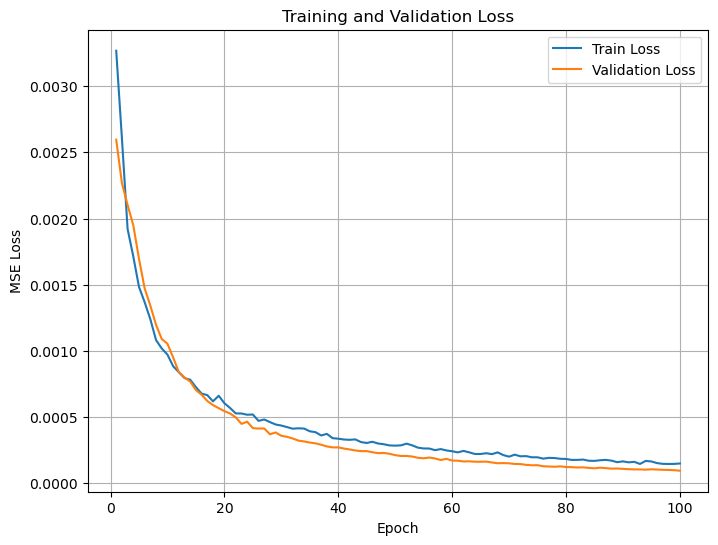

In [18]:
model = CNN_LSTM_Model(num_features=len(feature_cols))
train_and_validate(model, train_loader, val_loader, 100, 1e-5, 5)

Validation in log1p-transformed space:
MAE: 0.0077
RMSE: 0.0098
R2: 0.0525


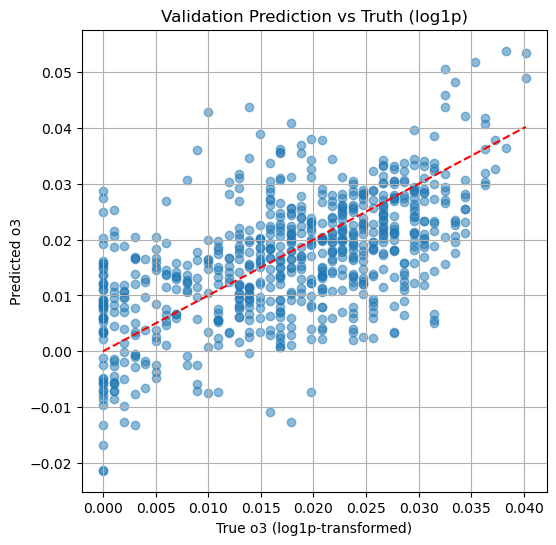

Validation in real concentration space (ppm):
MAE : 0.0078
RMSE: 0.0099
R2  : 0.0530


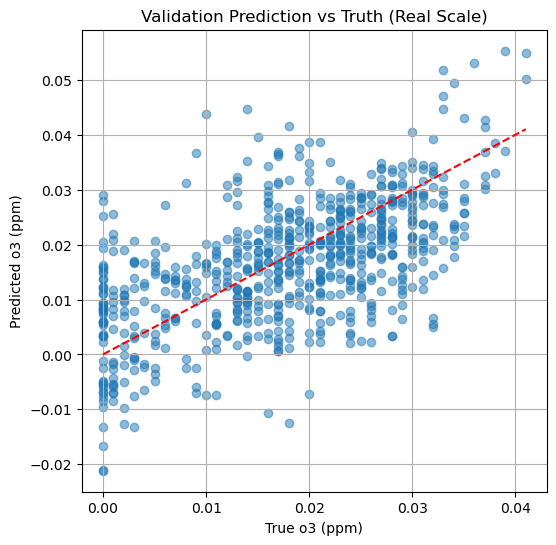

In [19]:
def evaluate_model_on_validation(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    preds = []
    trues = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds.append(outputs.cpu().numpy())
            trues.append(y_batch.cpu().numpy())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    mae = mean_absolute_error(trues, preds)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)

    print("Validation in log1p-transformed space:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")

    plt.figure(figsize=(6,6))
    plt.scatter(trues, preds, alpha=0.5)
    plt.xlabel('True o3 (log1p-transformed)')
    plt.ylabel('Predicted o3')
    plt.title('Validation Prediction vs Truth (log1p)')
    plt.plot([trues.min(), trues.max()], [trues.min(), trues.max()], 'r--')
    plt.grid(True)
    plt.show()

    preds_real = np.expm1(preds)
    trues_real = np.expm1(trues)

    mae_real = mean_absolute_error(trues_real, preds_real)
    rmse_real = np.sqrt(mean_squared_error(trues_real, preds_real))
    r2_real = r2_score(trues_real, preds_real)

    print("Validation in real concentration space (ppm):")
    print(f"MAE : {mae_real:.4f}")
    print(f"RMSE: {rmse_real:.4f}")
    print(f"R2  : {r2_real:.4f}")

    plt.figure(figsize=(6,6))
    plt.scatter(trues_real, preds_real, alpha=0.5)
    plt.xlabel('True o3 (ppm)')
    plt.ylabel('Predicted o3 (ppm)')
    plt.title('Validation Prediction vs Truth (Real Scale)')
    plt.plot([trues_real.min(), trues_real.max()], [trues_real.min(), trues_real.max()], 'r--')
    plt.grid(True)
    plt.show()

evaluate_model_on_validation(model, val_loader)

In [20]:
def predict_validation(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    preds = []
    trues = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds.append(outputs.cpu().numpy())
            trues.append(y_batch.cpu().numpy())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    preds_real = np.expm1(preds)
    trues_real = np.expm1(trues)

    return preds_real, trues_real

In [21]:
preds_real, trues_real = predict_validation(model, val_loader)
val_samples = val_dataset.samples

val_records = []
for x_seq, y_target in val_samples:
    val_records.append(y_target)

val_df = pd.DataFrame(val_records)
val_df = val_df.reset_index(drop=True)

val_df['val_o3'] = preds_real
val_df['true_o3'] = np.expm1(val_df['o3 measurement']) 

val_df['date'] = pd.to_datetime(val_df['date'])
val_df['time'] = val_df['time'].astype(str)
df['date'] = pd.to_datetime(df['date'])
df['time'] = df['time'].astype(str)

df = df.merge(
    val_df[['geometry', 'date', 'time', 'true_o3', 'val_o3']],
    on=['geometry', 'date', 'time'],
    how='left'
)

df.head()

,date,temperature_2m,lake_mix_layer_temperature,lake_shape_factor,snowfall,snowmelt,runoff,surface_runoff,sub_surface_runoff,evaporation_from_bare_soil,...,weekday,month,hour_sin,hour_cos,weekday_sin,weekday_cos,x,y,true_o3,val_o3
0,2024-01-01,0.661860,1.967718,-0.16762,-0.234687,-0.357112,0.103364,-0.198931,0.956666,-0.000355,...,0,1,0.0,1.0,0.0,1.0,-1.695582,-1.695582,NaN,NaN
1,2024-01-01,0.651576,1.907207,-0.16762,-0.234687,-0.357112,0.404562,-0.198977,2.049806,-0.000344,...,0,1,0.0,1.0,0.0,1.0,-1.621862,-1.695582,NaN,NaN
2,2024-01-01,0.651576,1.907207,-0.16762,-0.234687,-0.357112,0.404562,-0.198977,2.049806,-0.000344,...,0,1,0.0,1.0,0.0,1.0,-1.548141,-1.695582,NaN,NaN
3,2024-01-01,0.651576,1.907207,-0.16762,-0.234687,-0.357112,0.404562,-0.198977,2.049806,-0.000344,...,0,1,0.0,1.0,0.0,1.0,-1.474420,-1.695582,NaN,NaN
4,2024-01-01,0.651576,1.907207,-0.16762,-0.234687,-0.357112,0.404562,-0.198977,2.049806,-0.000344,...,0,1,0.0,1.0,0.0,1.0,-1.400699,-1.695582,NaN,NaN


In [22]:
df.shape

(1643496, 35)

In [23]:
'''mask = (
    (df['date'] == pd.to_datetime('2024-01-02')) &
    (df['time'] == '00:00')
)
slice_0000 = df[mask]

fig, ax = plt.subplots(figsize=(10, 10))
slice_0000.plot(
    column='o3 temp',
    cmap='viridis',
    legend=True,
    edgecolor='black',
    missing_kwds={'color': 'white'},
    ax=ax
)
ax.set_title('True o3 Concentration at 2024-01-02 00:00', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()'''


"mask = (\n    (df['date'] == pd.to_datetime('2024-01-02')) &\n    (df['time'] == '00:00')\n)\nslice_0000 = df[mask]\n\nfig, ax = plt.subplots(figsize=(10, 10))\nslice_0000.plot(\n    column='o3 temp',\n    cmap='viridis',\n    legend=True,\n    edgecolor='black',\n    missing_kwds={'color': 'white'},\n    ax=ax\n)\nax.set_title('True o3 Concentration at 2024-01-02 00:00', fontsize=14)\nax.set_axis_off()\nplt.tight_layout()\nplt.show()"

In [24]:
torch.save(model.state_dict(), '../model/model_o3.pth')

validation set points: 1


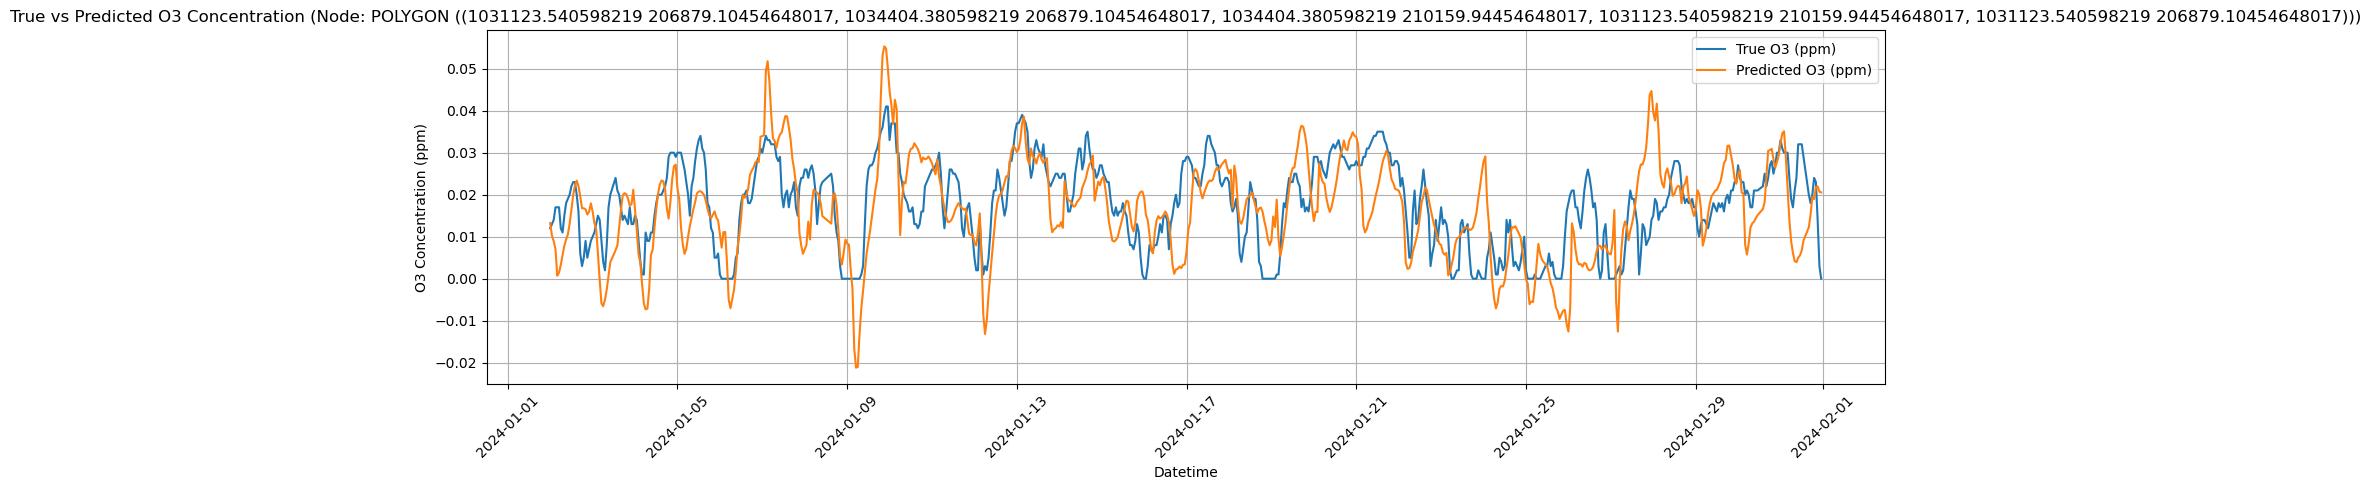

In [25]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

df_valid = df[~df['val_o3'].isna()].copy()
print(f'validation set points: {len(df_valid["geometry"].unique())}')
geometry_id = df_valid['geometry'].iloc[0]  

for geometry_id in df_valid['geometry'].unique():
    node_data = df_valid[df_valid['geometry'] == geometry_id].sort_values(['date', 'time'])
    # node_data = node_data[node_data['date'] <= '2024-01-02']
    node_data['datetime'] = pd.to_datetime(node_data['date'].astype(str) + ' ' + node_data['time'], format='%Y-%m-%d %H:%M')

    plt.figure(figsize=(15,5))
    plt.plot(node_data['datetime'], node_data['true_o3'], label='True O3 (ppm)')
    plt.plot(node_data['datetime'], node_data['val_o3'], label='Predicted O3 (ppm)')
    plt.xlabel('Datetime')
    plt.ylabel('O3 Concentration (ppm)')
    plt.title(f'True vs Predicted O3 Concentration (Node: {geometry_id})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [26]:
def predict_all_times_on_unmonitored(model, df, feature_cols, seq_len, batch_size=256):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.to(device)

    unmonitored_df = df[df['o3 measurement'].isna()].copy()
    unmonitored_df = unmonitored_df.sort_values(['geometry', 'date', 'time']).reset_index(drop=True)
    grouped = unmonitored_df.groupby('geometry')

    input_tensors = []
    meta_info = []

    for grid, grid_data in tqdm(grouped, desc="Sliding prediction by time"):
        grid_data = grid_data.reset_index(drop=True)
        grid_data[feature_cols] = grid_data[feature_cols].fillna(method='ffill').fillna(0)

        for i in range(seq_len, len(grid_data)):
            x_seq = grid_data.iloc[i-seq_len:i]
            target = grid_data.iloc[i]

            x_np = x_seq[feature_cols].values
            x_tensor = torch.tensor(x_np, dtype=torch.float32).unsqueeze(0)
            input_tensors.append(x_tensor)

            meta_info.append({
                'geometry': target['geometry'],
                'date': target['date'],
                'time': target['time']
            })

    if not input_tensors:
        return df

    input_tensor = torch.cat(input_tensors).to(device)
    preds = []

    with torch.no_grad():
        for i in range(0, len(input_tensor), batch_size):
            batch = input_tensor[i:i+batch_size]
            out = model(batch)
            out = torch.expm1(out).cpu().numpy().flatten()
            preds.extend(out)

    result_df = pd.DataFrame(meta_info)
    result_df['test_o3'] = preds

    df['date'] = pd.to_datetime(df['date'])
    df['time'] = df['time'].astype(str)
    result_df['date'] = pd.to_datetime(result_df['date'])
    result_df['time'] = result_df['time'].astype(str)

    df = df.merge(result_df, on=['geometry', 'date', 'time'], how='left')

    if 'o3 temp' in df.columns:
        df['test_o3'] = df['o3 temp'].combine_first(df['test_o3'])

    return df


In [27]:
df = predict_all_times_on_unmonitored(model, df, feature_cols, seq_len)


Sliding prediction by time: 100%|██████████| 2209/2209 [30:42<00:00,  1.20it/s]


In [28]:
df.to_csv('../output/df_o3.csv', index=False)
df.to_file('../output/df_o3.geojson', driver='GeoJSON')